# Assignment 3: Contractive and Denoising Autoencoders

## Author: Fabrizio De Castelli

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow.keras as K

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# comment all the following lines if run in local

"""

import sys
import os

current_dir = %pwd
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/FabriDeCastelli/ISPR-23-24.git
os.chdir("ISPR-23-24/assignment3")
"""

# until here

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"


#### Utility to load the MNIST dataset
Can specify the set to load: either 'training' or 'test'. This function provides the labels and the images.

In [2]:
def mnist(_set='training'):
    """
    Loads the MNIST dataset.

    :param _set: the set to load (either 'training' or 'test')
    
    :return: the images and the labels
    """

    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')

    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)

    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return data.astype('float32') / 255., labels

def add_noise(data, noise=0.1):
    """
    Adds noise to the data.

    :param data: the data to add noise to
    :param noise: the noise to add to the data

    :return: the data with noise
    """
    noisy = data + noise * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

def generate_noise(noise=1):
    """
    Generates noise to the data. The default noise is generated by a Normal distribution.

    :param noise: the noise to add to the data

    :return: the data with noise
    """
    noisy = noise * np.random.normal(loc=0.0, scale=1.0, size=(1, 784))
    return np.clip(noisy, 0., 1.)

def representative_images(data, targets, n=10):
    """
    Returns a representative image of the dataset.

    :param data: the images
    :param targets: the labels
    :param n: the number of representative images to return. Default is 10 (ten classes in MNIST)

    :return: n representative images, all of different classes
    """
    _, indices = np.unique(targets, return_index=True)
    return data[indices[:n]]


def plot_images(data, num_cols=10, title=""):
    """
    Plots the original and reconstructed images.

    :param data: the input data
    :param num_cols: the number of columns in the plot
    :param title: the title of the plot
    """
    num_images = len(data)
    num_rows = (num_images // num_cols) + (num_images % num_cols > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
    fig.text(0.5, 0.84, title, ha='center', fontsize=14)
    # In case we have only one row, the axs variable is not a list => convert it to a list
    if num_rows == 1:
        axs = [axs]
    
    for i in range(num_images):
        ax = axs[i // num_cols][i % num_cols]
        ax.set_title(f'Image {i}')
        ax.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    
    # Remove any empty subplots
    for i in range(num_images, num_cols * num_rows):
        fig.delaxes(axs[i // num_cols][i % num_cols])
        
    
    plt.tight_layout()
    plt.show()
    


## Deep Autoencoders

...


### Design Choices
- First choice.
- Second choice.

All the methods are implemented in the class Autoencoder. Brief descriptions of the methods are provided in the docstrings.

In [3]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(latent_dim // 2, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim // 2,)),
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def call(self, inputs, **kwargs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

    def generate(self, steps=100, num_images=10):
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        for i in range(num_images):
            noise_image = generate_noise()
        
            for _ in range(steps):
                noise_image = self.predict(noise_image, verbose=0)
    
            ax = axes[i]
            ax.imshow(noise_image.reshape(28, 28), cmap='gray')
            ax.axis('off') 
        
        plt.show()
        

    def plot_latent_space(self, n: int = 30, figsize: int = 15):
        """
        Plots a 2D manifold of digits in the latent space
        
        :param n: number of digits to plot in the manifold
        :param figsize: size of the figure

        """
        digit_size = 28
        scale = 1.0
        figure = np.zeros((digit_size * n, digit_size * n))
        
        grid_x = np.linspace(0, scale, n)
        grid_y = np.linspace(0, scale, n)[::-1]
        
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                noisy_image = np.zeros((1, 784)) + np.random.normal(loc=0, scale=(yi+xi)/2, size=(1, 784))
                x_decoded = self.predict(noisy_image, verbose=0)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap="Greys_r")
        plt.show()
        

In [4]:
# load the MNIST dataset
training_images, training_labels = mnist('training')
test_images, test_labels = mnist('test')

# add noise to the data
noise_factor = 0.5
training_noisy_images = add_noise(training_images, noise_factor)
test_noisy_images = add_noise(test_images, noise_factor)

In [6]:
denoising_autoencoder = Autoencoder(latent_dim=512)

denoising_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

denoising_autoencoder.fit(
    training_noisy_images, 
    training_images, 
    epochs=20, 
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(test_noisy_images, test_images),
    verbose=2
)

Epoch 1/20
469/469 - 2s - loss: 0.0376 - val_loss: 0.0216 - 2s/epoch - 5ms/step
Epoch 2/20
469/469 - 2s - loss: 0.0198 - val_loss: 0.0178 - 2s/epoch - 4ms/step
Epoch 3/20
469/469 - 2s - loss: 0.0171 - val_loss: 0.0161 - 2s/epoch - 4ms/step
Epoch 4/20
469/469 - 2s - loss: 0.0157 - val_loss: 0.0154 - 2s/epoch - 4ms/step
Epoch 5/20
469/469 - 2s - loss: 0.0148 - val_loss: 0.0148 - 2s/epoch - 5ms/step
Epoch 6/20
469/469 - 2s - loss: 0.0141 - val_loss: 0.0143 - 2s/epoch - 4ms/step
Epoch 7/20
469/469 - 2s - loss: 0.0136 - val_loss: 0.0143 - 2s/epoch - 4ms/step
Epoch 8/20
469/469 - 2s - loss: 0.0132 - val_loss: 0.0142 - 2s/epoch - 4ms/step
Epoch 9/20
469/469 - 2s - loss: 0.0128 - val_loss: 0.0138 - 2s/epoch - 4ms/step
Epoch 10/20
469/469 - 2s - loss: 0.0125 - val_loss: 0.0135 - 2s/epoch - 4ms/step
Epoch 11/20
469/469 - 2s - loss: 0.0122 - val_loss: 0.0134 - 2s/epoch - 4ms/step
Epoch 12/20
469/469 - 2s - loss: 0.0120 - val_loss: 0.0134 - 2s/epoch - 4ms/step
Epoch 13/20
469/469 - 2s - loss: 0.01

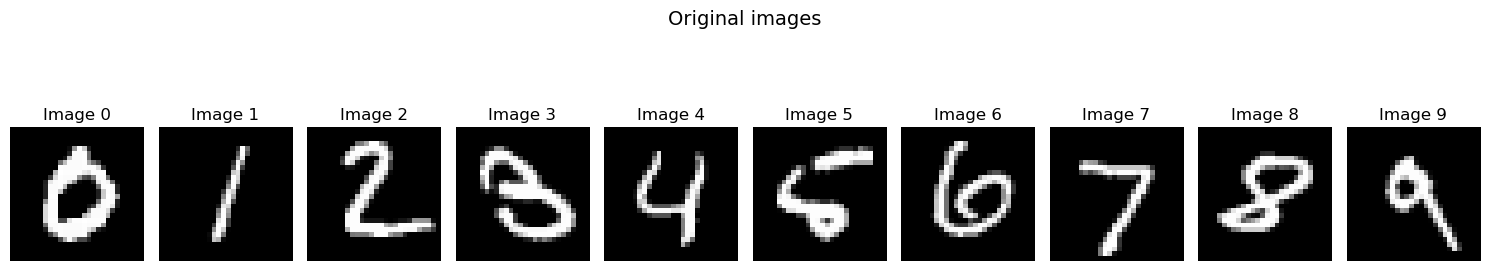

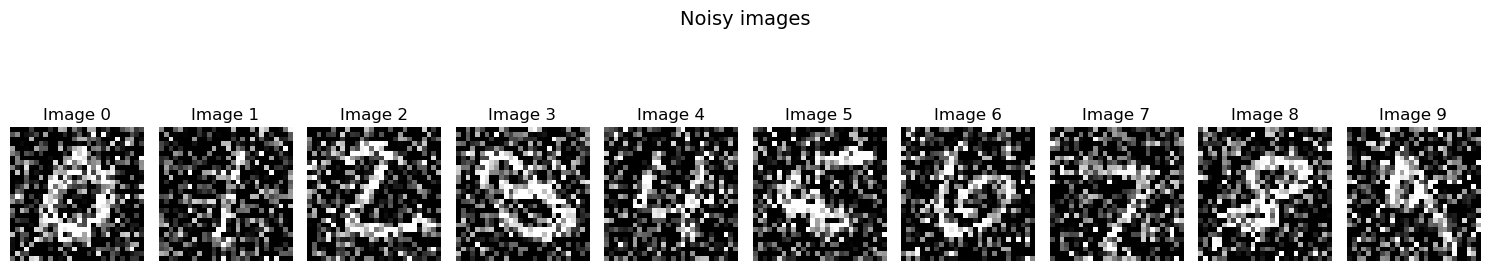

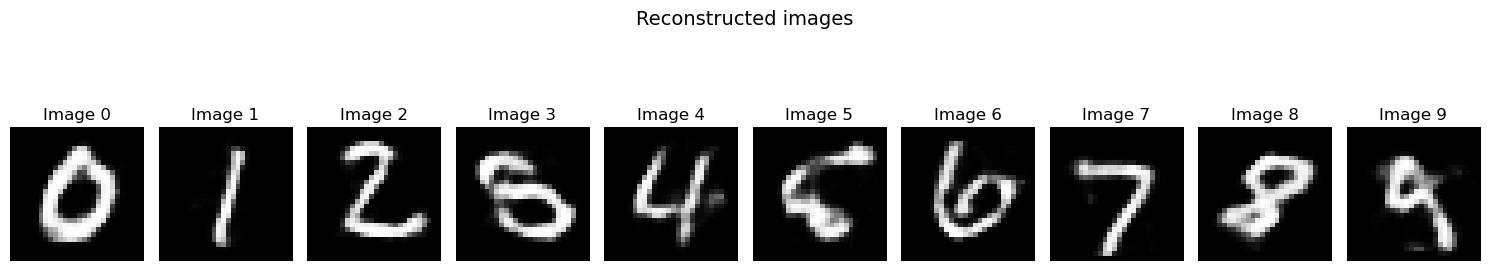

In [7]:
# Plot the original and reconstructed images
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_noisy = representative_images(test_noisy_images, test_labels)
zero_to_ten_reconstruction = denoising_autoencoder(zero_to_ten_noisy).numpy()
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_noisy, title="Noisy images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

In [ ]:
denoising_autoencoder.generate(steps=1000)

In [ ]:
denoising_autoencoder.plot_latent_space()

In [142]:
def contractive_loss(encoder, lam):
    
    @tf.function
    def loss(reconstruction, original):
        mse = losses.MeanSquaredError()(reconstruction, original)
        with tf.GradientTape() as tape:
            tape.watch(original)
            z = encoder(original)
        encoding_gradients = tape.gradient(z, original)
        frobenius_norm = tf.reduce_sum(tf.square(encoding_gradients), axis=1)
        return mse + lam * frobenius_norm
    
    return loss


contractive_autoencoder = Autoencoder(latent_dim=512)

contractive_l = contractive_loss(contractive_autoencoder.encoder, 1e-4)

contractive_autoencoder.compile(optimizer='adam', loss=contractive_l)

early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

contractive_autoencoder.fit(
    training_noisy_images, 
    training_images, 
    batch_size=256,
    epochs=50, 
    callbacks=[early_stopping],
    validation_data=(test_noisy_images, test_images),
    verbose=2
)


Epoch 1/50
235/235 - 3s - loss: 0.0649 - val_loss: 0.0493 - 3s/epoch - 14ms/step
Epoch 2/50
235/235 - 3s - loss: 0.0449 - val_loss: 0.0426 - 3s/epoch - 12ms/step
Epoch 3/50
235/235 - 3s - loss: 0.0401 - val_loss: 0.0390 - 3s/epoch - 14ms/step
Epoch 4/50
235/235 - 3s - loss: 0.0376 - val_loss: 0.0367 - 3s/epoch - 13ms/step
Epoch 5/50
235/235 - 3s - loss: 0.0358 - val_loss: 0.0358 - 3s/epoch - 13ms/step
Epoch 6/50
235/235 - 3s - loss: 0.0345 - val_loss: 0.0352 - 3s/epoch - 13ms/step
Epoch 7/50
235/235 - 3s - loss: 0.0333 - val_loss: 0.0350 - 3s/epoch - 14ms/step
Epoch 8/50
235/235 - 3s - loss: 0.0323 - val_loss: 0.0342 - 3s/epoch - 13ms/step
Epoch 9/50
235/235 - 3s - loss: 0.0313 - val_loss: 0.0334 - 3s/epoch - 12ms/step
Epoch 10/50
235/235 - 3s - loss: 0.0306 - val_loss: 0.0334 - 3s/epoch - 12ms/step
Epoch 11/50
235/235 - 3s - loss: 0.0299 - val_loss: 0.0335 - 3s/epoch - 13ms/step
Epoch 12/50
235/235 - 3s - loss: 0.0292 - val_loss: 0.0334 - 3s/epoch - 13ms/step
Epoch 13/50
235/235 - 3s 

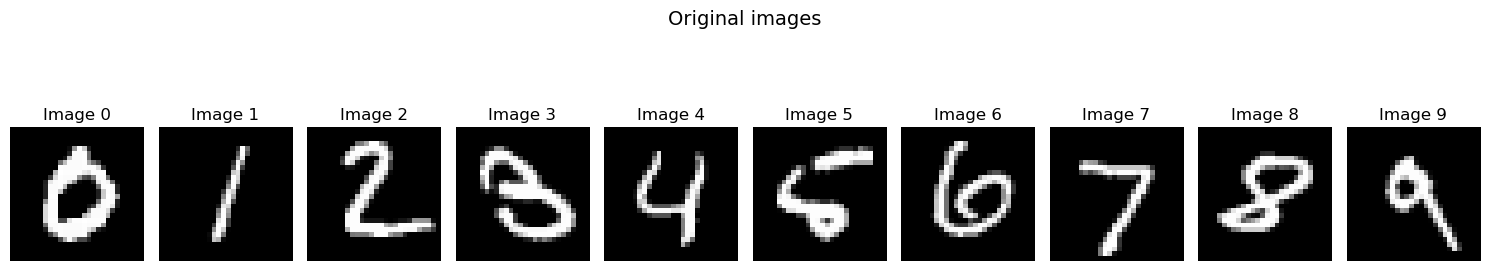

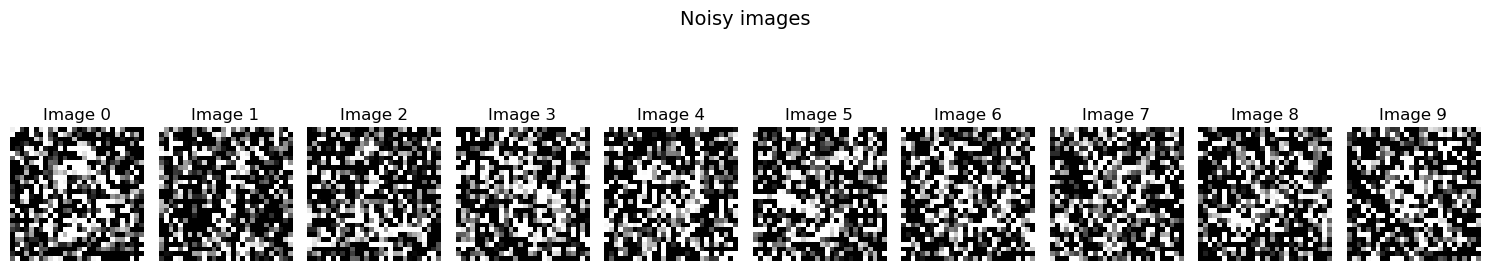

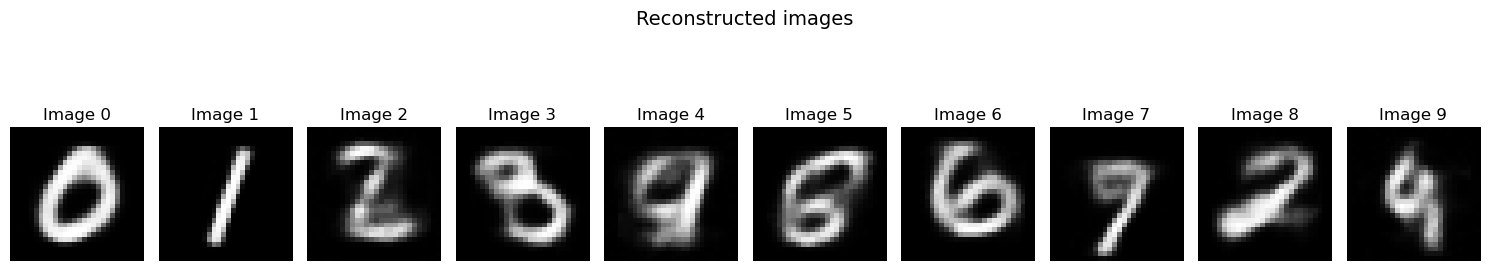

In [143]:
# Plot the original and reconstructed images
zero_to_ten = representative_images(test_images, test_labels)
zero_to_ten_noisy = representative_images(test_noisy_images, test_labels)
zero_to_ten_reconstruction = contractive_autoencoder(zero_to_ten_noisy).numpy()
plot_images(zero_to_ten, title="Original images")
plot_images(zero_to_ten_noisy, title="Noisy images")
plot_images(zero_to_ten_reconstruction, title="Reconstructed images")

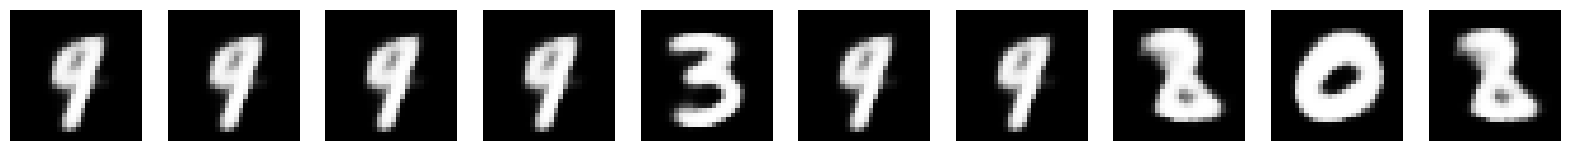

In [144]:
contractive_autoencoder.generate(steps=1000)

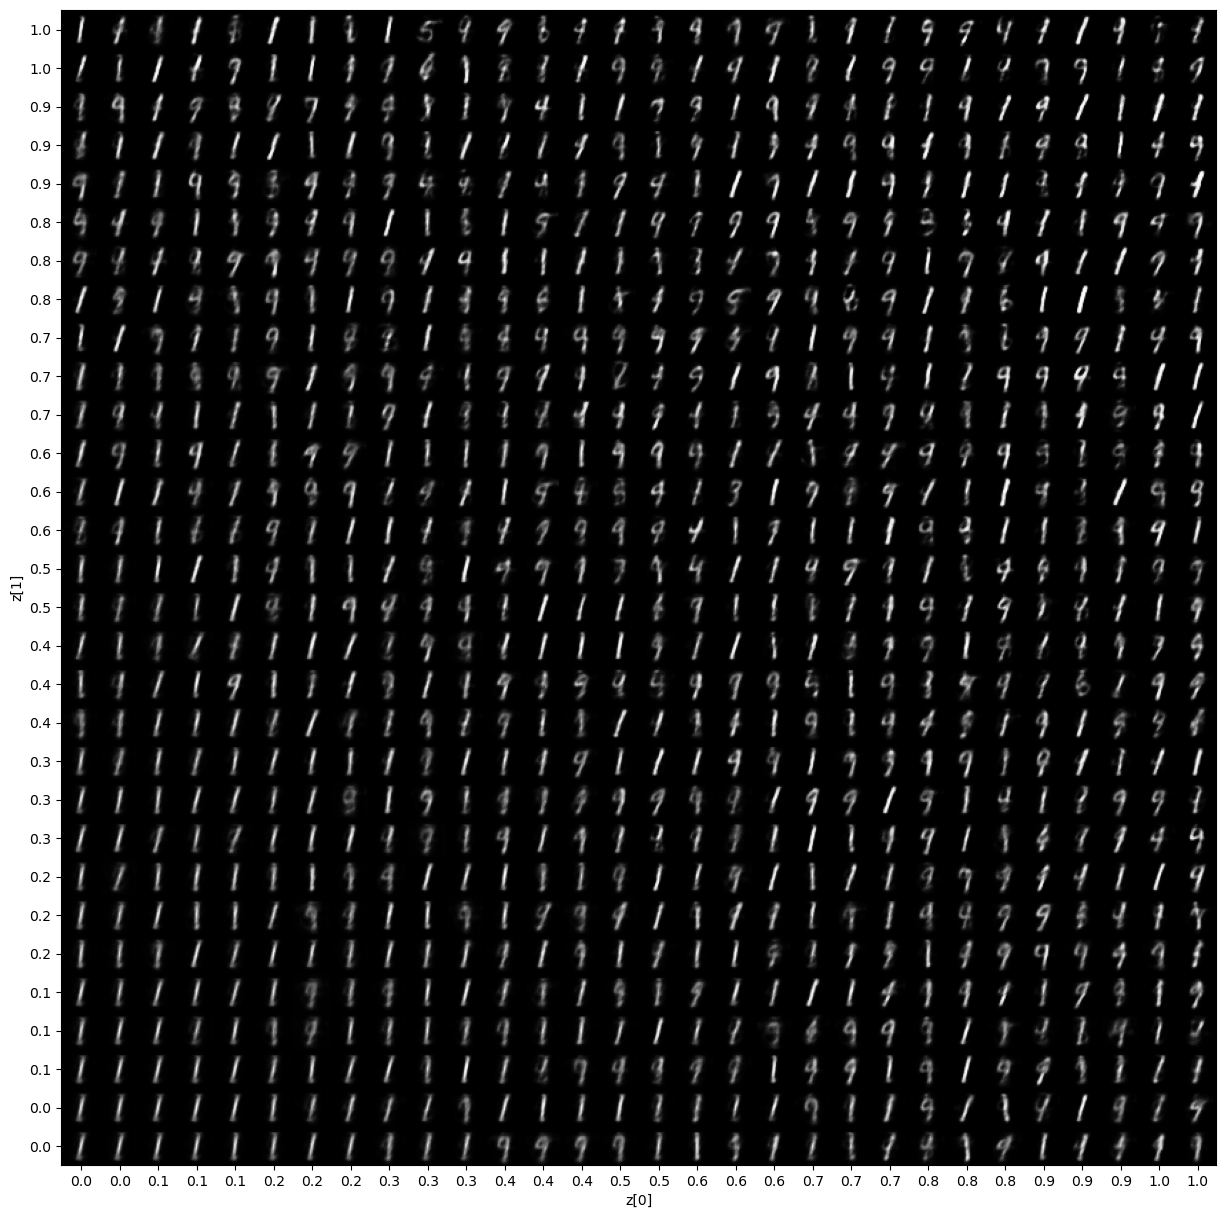

In [145]:
contractive_autoencoder.plot_latent_space()

## Conclusions

In this assignment, we implemented ...